Tianxiang Chen tc2176

CS-GY 6613 Artificial Intelligence

Project 1




***Introduction:***

*The task of this project is to help identify the floor surface that the robot is on, with the analysis of collected IMU sensor data to navigate the robot through different surface materials.*

In [1085]:
#Imports

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn
import time
import math
import os
import warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [1086]:
#Load Data Files

trainx = pd.read_csv('../input/career-con-2019/X_train.csv')
trainy = pd.read_csv('../input/career-con-2019/y_train.csv')
test = pd.read_csv('../input/career-con-2019/X_test.csv')
submission = pd.read_csv('../input/career-con-2019/sample_submission.csv')

In [1087]:
#test data

#trainx = pd.read_csv('../input/testcheck/X_train_new.csv')
#trainy = pd.read_csv('../input/testcheck/y_train_new.csv')
#test = pd.read_csv('../input/testcheck/X_test_new.csv')
#testy = pd.read_csv('../input/testcheck/y_test_new.csv')

In [1088]:
print('X_train: \nrows: {} \ncolumns: {} \n'.format(trainx.shape[0],trainx.shape[1]))
print('y_train: \nrows: {} \ncolumns: {} \n'.format(trainy.shape[0],trainy.shape[1]))
print('X_test: \nrows: {} \ncolumns: {} '.format(test.shape[0],test.shape[1]))

X_train: 
rows: 487680 
columns: 13 

y_train: 
rows: 3810 
columns: 3 

X_test: 
rows: 488448 
columns: 13 


In [1089]:
trainx.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


################################***Analyze and Observe Data***#############################


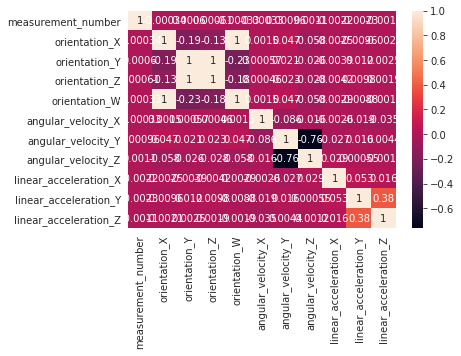

In [1090]:
correlation = trainx.drop(columns = ['series_id'], axis = 1).corr(method = 'pearson')
seaborn.heatmap(correlation, annot = True)

***From the heatmap,* **there is strong correlation between:
1. orientation_X and orientation_W
2. orientation_Y and orientation_Z
3. linear_acceleartion_Y and linear_accleration_Z

***In the meanwhile,* **there is negative correlation between:
1. angular_velocity_Y and angular_velocity_Z
2. orientation_Y and orientation_W
3. orientation_Z and orientation_W
4. orientation_Y and orientation_X
5. orientation_Z and orientation_X



In [1091]:
frequencyChart = trainy['surface'].value_counts(normalize = True).rename_axis('surface').reset_index(name = 'frequency')
frequencyChart

,surface,frequency
0,concrete,0.204462
1,soft_pvc,0.192126
2,wood,0.159318
3,tiled,0.134908
4,fine_concrete,0.095276
5,hard_tiles_large_space,0.080840
6,soft_tiles,0.077953
7,carpet,0.049606
8,hard_tiles,0.005512


**Observations:** 
1. The frequency of hard_tiles is significantly the least.

       => Implication: there is most limited data on hard_tiles available to build the model.
               
2. The frequencies of concrete, soft_pvc, wood, and tiled are significantly higher than others.

       => Implication: derived model is more likely to predict surfaces of these materials than others.

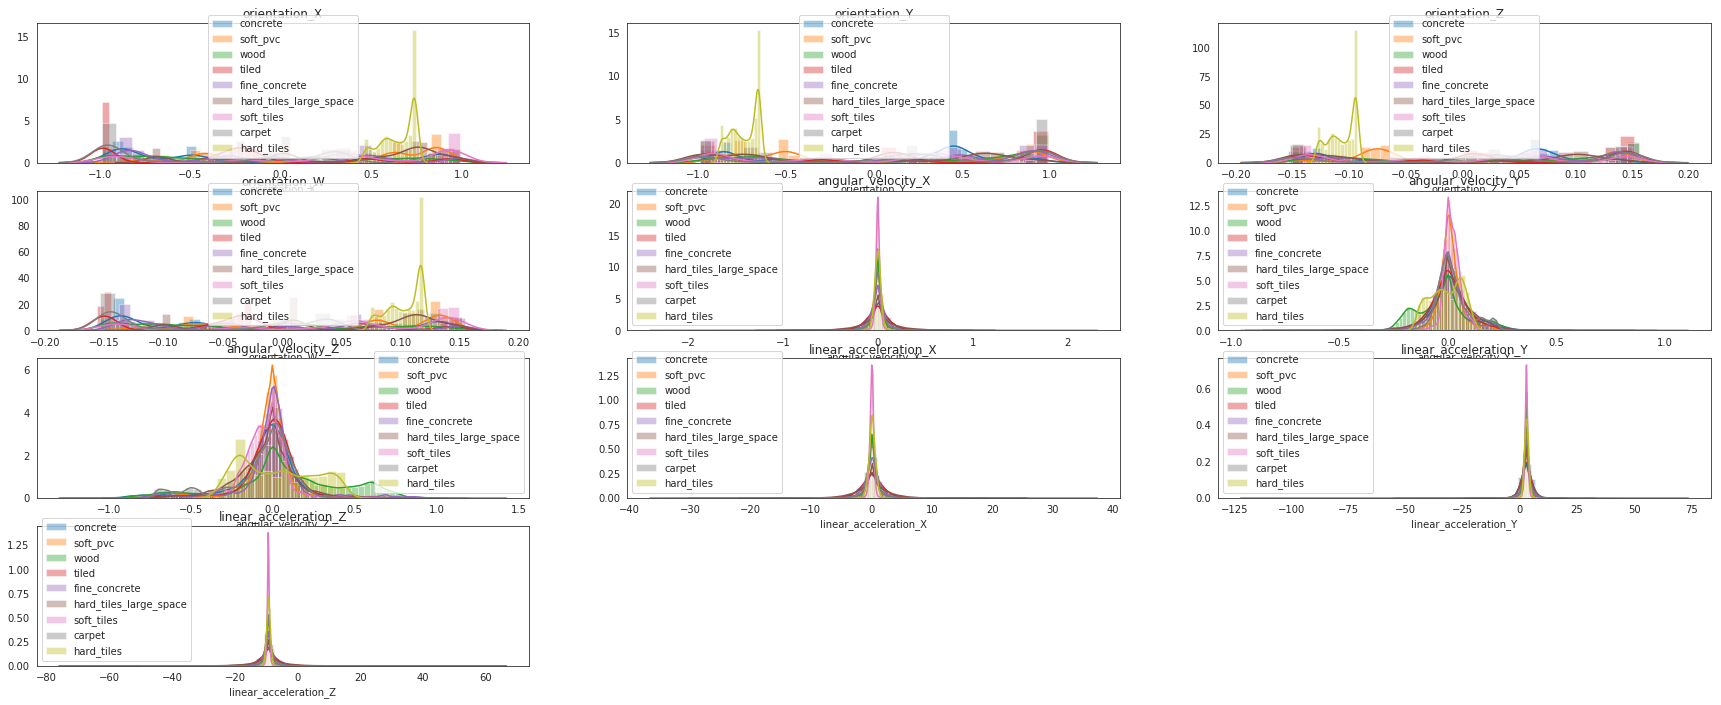

In [1092]:
# surface types vs. features
plotFile = trainx.merge(trainy, on='series_id', how='inner')
plt.figure(figsize = (30, 18))
seaborn.set_style('white')
i = 0

for i, col in enumerate(plotFile.columns):
    if col in ['Unnamed: 0_x', 'Unnamed: 0_y', 'row_id', 'series_id', 'measurement_number','group_id','surface']:
          continue
    plt.subplot(6, 3, i + 1)
    plt.title(col)
    for surface in trainy['surface'].value_counts(normalize = True).index:
        features = plotFile[plotFile['surface'] == surface]
        seaborn.distplot(features[col],label = surface, rug = False, hist = True)
        plt.legend()
    

1.  From above graphs, we can also observe that features of hard_tiles are more likely to vary hugely with limited data available. 

    => This aligns with our observations from the frequency chart that frequency of hard_tiles is the least. 
   
    => We would need to introduce other features generated from current orientation / linear_acceleration / angular_velocity data for each entry.


2.  Other surface types are also less consistent regarding orientation features. 

    => Feature engineering is necessary to addresss these variations.

################################### ***Feature Processing*** #################################

There are 128 measurements for each entry of series_id. We would implement feature engineering based on these 128 measurements for each individual entry of series_id.

Generated features include mean, median, max, min, standard deviation, mean absolute deviation, max to min, range, quantile(0.99), quantile(0.95), quantile(0.90), quantile(0.50), quantile(0.10), quantile(0.05), and quantile(0.01).

In [1093]:
def processData(data):
    df = pd.DataFrame()
    for col in data.columns:
        
        #skip categorical columns
        if col in ['Unnamed: 0','row_id', 'series_id', 'measurement_number']:
            continue
        
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_mad'] = data.groupby(['series_id'])[col].mad()
        df[col + '_range'] = data.groupby(['series_id'])[col].max() - data.groupby(['series_id'])[col].min()
        df[col + '_maxtomin'] = data.groupby(['series_id'])[col].max()/data.groupby(['series_id'])[col].min()
        df[col + '_quant0.99'] = data.groupby(['series_id'])[col].quantile(0.99)
        df[col + '_quant0.95'] = data.groupby(['series_id'])[col].quantile(0.95)
        df[col + '_quant0.90'] = data.groupby(['series_id'])[col].quantile(0.9)
        df[col + '_quant0.50'] = data.groupby(['series_id'])[col].quantile(0.5)
        df[col + '_quant0.10'] = data.groupby(['series_id'])[col].quantile(0.1)
        df[col + '_quant0.05'] = data.groupby(['series_id'])[col].quantile(0.05)
        df[col + '_quant0.01'] = data.groupby(['series_id'])[col].quantile(0.01)
                                      
    return df
        

In [1094]:
xtrain = trainx.copy()
xtest = test.copy()
xtrain = processData(xtrain)
xtest = processData(xtest)
xtrain.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_mad,orientation_X_range,orientation_X_maxtomin,orientation_X_quant0.99,orientation_X_quant0.95,...,linear_acceleration_Z_mad,linear_acceleration_Z_range,linear_acceleration_Z_maxtomin,linear_acceleration_Z_quant0.99,linear_acceleration_Z_quant0.95,linear_acceleration_Z_quant0.90,linear_acceleration_Z_quant0.50,linear_acceleration_Z_quant0.10,linear_acceleration_Z_quant0.05,linear_acceleration_Z_quant0.01
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.000311,0.00131,0.998275,-0.758223,-0.758240,...,0.839636,6.2439,0.500967,-6.814420,-7.538790,-8.00948,-9.42995,-10.5599,-11.10455,-11.93731
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.000126,0.00059,0.999385,-0.958380,-0.958390,...,1.562716,14.1831,0.162151,-4.850184,-5.726810,-7.07713,-9.41380,-11.9065,-12.37800,-14.95379
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.001144,0.00490,0.990473,-0.509506,-0.509841,...,0.889865,6.7548,0.459573,-6.704474,-7.513410,-8.09027,-9.37440,-10.7449,-11.28975,-11.88847
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.000197,0.00084,0.999106,-0.938850,-0.938850,...,2.601023,19.2859,0.028173,-1.670132,-3.645385,-5.29569,-9.16170,-13.2767,-15.84915,-18.33046
4,-0.891301,-0.890940,-0.88673,-0.89689,0.002955,0.002562,0.01016,0.988672,-0.886832,-0.887157,...,0.654576,3.5260,0.678724,-7.673845,-7.861125,-8.26950,-9.33280,-10.3969,-10.73880,-10.91112


In [1095]:
xtrain.shape

(3810, 150)

Fill in the Null Values if found any in processed xtrain and xtest. But no Null values found in the train data.

In [1096]:
def fillNull(data):
    data.fillna(0, inplace = True)
    return data

In [1097]:
trainNull = xtrain.isnull().sum().sum()
testNull = xtest.isnull().sum().sum()

if trainNull > 0:
    xtrain = fillNull(xtrain)
if testNull > 0:
    xtest = fillNull(xtest)

################################# ***Model Choice Process*** ###############################

SVC, Random Forest, and Logistic Regresion

Following are three models of SVC, Random Forest, and Logistic Regression. I let each model to compute the respective accuracy and choose the model with the best accuracy based on accuracy from the train data. 

From my comprehensive attempts, Random Forest has significantly higher accuracy score than SVC and Logistic Regression. If to choose only one model, I would utilize **Random Forest Algorithm **to build the model for this project, based on the pros of providing more accuracy and less variance than the single Decsion Tree, even with longer running time.

With more features generated, the significant advantage of Random Forest in accuracy emerges:

==> With 10 original features in train data, accuracy average: 
      1. Random Forest             0.5359045946002468
      2. SVC                       0.3413244243679026
      3. Logistic Regression       0.2844218583349018

==> With 100 generated features, accuracy averages change significantly:
      1. Random Forest             0.8884068427546689
      2. Logistic Regression       0.4633352155091286
      3. SVC                       0.3910272497229023
    



In [1098]:
n_fold = 15
folds = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 60)

In [1099]:
le = LabelEncoder()
trainy['surface'] = le.fit_transform(trainy['surface'])

In [1100]:
#Random Forest Classfication
rfAccuracy = []
totalRF = 0

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(xtrain.values, trainy['surface'].values)):
        X_train = xtrain.iloc[train_idx]
        X_valid = xtrain.iloc[valid_idx]
        y_train = trainy['surface'][train_idx]
        y_valid = trainy['surface'][valid_idx]
        
        rfmodel = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
        rfmodel.fit(X_train, y_train)
        predict_y = rfmodel.predict(X_valid)
        
        rfAccuracy.insert(n_fold, accuracy_score(y_valid,predict_y))
        totalRF = totalRF + rfAccuracy[n_fold]


In [1101]:
rfAccuracy

[0.8858267716535433,
 0.8976377952755905,
 0.905511811023622,
 0.8976377952755905,
 0.8700787401574803,
 0.8858267716535433,
 0.8858267716535433,
 0.8818897637795275,
 0.8543307086614174,
 0.8818897637795275,
 0.9173228346456693,
 0.8740157480314961,
 0.8661417322834646,
 0.905511811023622,
 0.8818897637795275]

In [1102]:
averageRF = totalRF / 15
averageRF

0.8860892388451445

In [1103]:
#SVC
svcAccuracy = []
totalSVC = 0

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(xtrain.values, trainy['surface'].values)):
        X_train = xtrain.iloc[train_idx]
        X_valid = xtrain.iloc[valid_idx]
        y_train = trainy['surface'][train_idx]
        y_valid = trainy['surface'][valid_idx]
        
        svc = SVC()
        svc.fit(X_train, y_train)
        predict_y = svc.predict(X_valid)
        
        svcAccuracy.insert(n_fold, accuracy_score(y_valid,predict_y))
        totalSVC = totalSVC + svcAccuracy[n_fold]

In [1104]:
svcAccuracy

[0.4330708661417323,
 0.40551181102362205,
 0.3779527559055118,
 0.4251968503937008,
 0.4094488188976378,
 0.38976377952755903,
 0.35826771653543305,
 0.40551181102362205,
 0.41338582677165353,
 0.38976377952755903,
 0.3779527559055118,
 0.39763779527559057,
 0.39763779527559057,
 0.37401574803149606,
 0.39763779527559057]

In [1105]:
averageSVC = totalSVC / 15
averageSVC

0.39685039370078745

In [1106]:
#Logistic Regression

lrAccuracy = []
totalLR = 0

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(xtrain.values, trainy['surface'].values)):
        X_train = xtrain.iloc[train_idx]
        X_valid = xtrain.iloc[valid_idx]
        y_train = trainy['surface'][train_idx]
        y_valid = trainy['surface'][valid_idx]
        
        lrmodel = LogisticRegression()
        lrmodel.fit(X_train, y_train)
        predict_y = lrmodel.predict(X_valid)
        
        lrAccuracy.insert(n_fold, accuracy_score(y_valid,predict_y))
        totalLR = totalLR + lrAccuracy[n_fold]

In [1107]:
lrAccuracy

[0.484251968503937,
 0.4330708661417323,
 0.468503937007874,
 0.5,
 0.4251968503937008,
 0.4448818897637795,
 0.44881889763779526,
 0.5118110236220472,
 0.43700787401574803,
 0.4330708661417323,
 0.4763779527559055,
 0.47244094488188976,
 0.47244094488188976,
 0.46062992125984253,
 0.5039370078740157]

In [1108]:
averageLR = totalLR / 15
averageLR

0.46482939632545933

=>   Random Forest Model is significantly better than SVC and Logistic Regression Model, regarding its higher accuracy score. 

=>  But I still introduce the following comparison part to select the best-performing model, in case of cross-validation kfold favoring any specific model.

In [1109]:
if averageRF > averageSVC:
    if averageRF > averageLR:
        #choose random forest basically all the time with its best accuracy score
        y = rfmodel.predict(xtest)
    else:
        #choose Logistic Regression
        y = lrmodel.predict(xtest)
else:
    if averageSVC > averageLR:
        #choose SVC
        y = svc.predict(xtest)
    else:
        #choose Logistic Regression
        y = lrmodel.predict(xtest)

In [1110]:
#random forest
#y = rfmodel.predict(xtest)

In [1111]:
submission = pd.read_csv('../input/career-con-2019/sample_submission.csv')
submission['surface'] = le.inverse_transform(y)
submission.to_csv('submission.csv', index = False)
submission.head(20)

,series_id,surface
0,0,soft_pvc
1,1,wood
2,2,concrete
3,3,wood
4,4,concrete
5,5,wood
6,6,soft_pvc
7,7,concrete
8,8,soft_tiles
9,9,wood
